# Goal

* Run `paco` analysis on IndD dataset summed by host
* Sensitivity analysis (family-level): selecting one sample per family

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# host phylogeny
host_tree_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_20180625_rn_16S-r5k_IndD.nwk'

# misc
sparsity_cutoff = 0.05
threads = 12

# Init

In [4]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(stringr)
library(phyloseq)
library(ape)
library(paco)

library(future)
library(future.batchtools)
library(future.apply)

options(future.wait.interval = 2.0)
source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 

In [5]:
make_dir(work_dir)
setwd(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/ 


In [6]:
rescale_dist_mtx = function(m){
    m = m %>% as.matrix
    labs = m %>% colnames
    n_row = m %>% nrow
    n_col = m %>% ncol
    x = m %>% as.vector 
    x = scales::rescale(x) 
    m = matrix(x, nrow=n_row, ncol=n_col)
    colnames(m) = labs
    rownames(m) = labs
    m = m %>% as.dist
    return(m)
}

# Load

In [7]:
physeq = readRDS(physeq_file)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 30290 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 30290 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 30290 tips and 29752 internal nodes ]

In [8]:
physeq = physeq %>%
    filter_taxa(function(x) sum(x > 0) / length(x) > sparsity_cutoff, TRUE) 
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 408 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 408 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 408 tips and 406 internal nodes ]

In [9]:
host_tree = read.tree(host_tree_file)
host_tree


Phylogenetic tree with 213 tips and 177 internal nodes.

Tip labels:
	X256.Zander, F302.Northern.Pike, X188.Brook.Trout, F300.Asp, X330.Ide, X327.Silver.Bream, ...
Node labels:
	Node1, Node2, Node3, Node4, Node5, Node6, ...

Rooted; includes branch lengths.

# Filtering dataset

## OTU table

In [10]:
physeq %>%
    otu_table %>% 
    colSums %>%
    summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     210    1172    1453    2538    4995 

In [11]:
metadata = physeq %>%
    sample_data %>%
    dplyr::select(family, scientific_name) %>%
    mutate(SampleID = rownames(.)) %>%
    as.data.frame

rownames(metadata) = metadata$SampleID
#metadata$sample = NULL

metadata %>% dfhead

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

[1] 213   3


,family,scientific_name,SampleID
X1.Eurasian.Beaver,Castoridae,Castor_fiber,X1.Eurasian.Beaver
X101.Horse,Equidae,Equus_caballus,X101.Horse
X102.Kulan,Equidae,Equus_hemionus,X102.Kulan


In [12]:
# number of genera
metadata$family %>% unique %>% length

[1] 73

# Subsampling tree

* multiple subsamples: one sample per species

In [13]:
# number of subsampled trees
ntrees = 100

In [14]:
#' randomly selecting one per group (family)
tree_subsample = function(L, df, tree){
    # get subsample (note: subsampling within each species)
    to_keep = df %>% 
        group_by(family) %>% 
        sample_n(1) %>%
        .$sample
    # subsampling tree
    to_rm = setdiff(tree$tip.label, to_keep)
    tree = drop.tip(tree, to_rm)
    #tree$tip.label %>% length %>% print
    return(tree)
}

In [15]:
df = metadata %>%
    mutate(sample = rownames(.)) %>%
    dplyr::select(sample, family) 

doParallel::registerDoParallel(threads)
host_tree_l = plyr::llply(as.list(1:ntrees), 
                          function(x) tree_subsample(x, df, host_tree),
                          .parallel=TRUE)
host_tree_l %>% length

[1] 100

In [16]:
# samples per tree
host_tree_l %>% lapply(function(x) length(x$tip.label)) %>% unlist %>% as.vector %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     73      73      73      73      73      73 

# paco: diffused model

* on each subsample

## Creating datasets

In [17]:
make_paco_input = function(host_tree, physeq){
    # subsampled phyloseq object
    physeq_f = prune_samples(sample_names(physeq) %in% host_tree$tip.label, 
                             physeq) 

    # microbial distance matrix
    micro_D = physeq_f %>%
        phy_tree %>% cophenetic %>% 
        rescale_dist_mtx %>% as.matrix
    # host distance matrix
    host_D = host_tree %>% cophenetic %>% 
             rescale_dist_mtx %>% as.matrix
    
    # otu abundance matrix
    otu = physeq_f %>% 
        otu_table %>%
        as.data.frame %>%
        as.matrix %>%
        t %>%
        apply(2, function(x) ifelse(x > 0, 1, 0)) %>% as.matrix                
              
              
    # checking overlap
    x = length(intersect(rownames(otu), rownames(host_D)))
    y = length(union(rownames(otu), rownames(host_D)))
    stopifnot(x == y)
              
    # preparing paco data
    D = prepare_paco_data(H=host_D, P=micro_D, HP=otu)
    D = add_pcoord(D, correction='cailliez')
    return(D)
}

In [18]:
doParallel::registerDoParallel(threads)
paco_l = plyr::llply(host_tree_l, make_paco_input, physeq=physeq, .parallel=TRUE)
paco_l %>% length

[1] 100

## Running paco

In [19]:
# for loading results instead of re-running
PACo_file = file.path(work_dir, 'physeq_IndD-sens-family_PACo.RDS')
PACo_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT//physeq_IndD-sens-family_PACo.RDS"

In [21]:
# cluster resources
resources = list(h_rt = '24:00:00',
                 h_vmem = '10G',
                 threads = '1',
                 conda.env = 'py3_physeq_phylo', 
                 conda.path = '/ebio/abt3_projects/software/miniconda3_gt4.4/bin')
plan(batchtools_sge, resources=resources)

In [22]:
# Running paco on each subsample
## WARNING: SLOW!
paco_each = function(D, nperm=99, seed=3843){
    PACo(D, nperm=nperm, seed=seed, method='quasiswap', symmetric=TRUE)
}

paco_res_l = future_lapply(paco_l, paco_each, nperm=999, future.packages=c('paco'))
paco_res_l %>% length

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vec

[1] 100

In [23]:
# save results
saveRDS(paco_res_l, PACo_file)
cat('File written:', PACo_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT//physeq_IndD-sens-family_PACo.RDS 


In [24]:
# load results
paco_res_l = readRDS(PACo_file)
paco_res_l %>% length

[1] 100

## Formatting output

In [25]:
# goodness of fit
gof = lapply(paco_res_l, function(x) as.vector(x$gof)) %>% 
        do.call(rbind, .) %>%
        as.data.frame
             
gof$p %>% as.Num %>% summary %>% print
gof$ss %>% as.Num %>% summary %>% print

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9568  0.9605  0.9627  0.9626  0.9649  0.9703 


In [26]:
# clearing memory; the `paco_res_l` object is huge
#paco_res_l = NULL

## Individual contributions

In [27]:
# for loading results instead of re-running
PACo_links_file = file.path(work_dir, 'physeq_IndD-sens-family_PACo-links.RDS')
PACo_links_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT//physeq_IndD-sens-family_PACo-links.RDS"

In [28]:
#-- WARNING: SLOW --#
# cluster resources
resources = list(h_rt = '36:00:00',
                 h_vmem = '10G',
                 threads = '1',
                 conda.env = 'py3_physeq_phylo', 
                 conda.path = '/ebio/abt3_projects/software/miniconda3_gt4.4/bin')
plan(batchtools_sge, resources=resources)

# running
D_links_l = future_lapply(paco_res_l, paco_links, future.packages=c('paco'))
D_links_l %>% length

[1] 100

In [29]:
# saving object
saveRDS(D_links_l, PACo_links_file)
cat('File written:', PACo_links_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT//physeq_IndD-sens-family_PACo-links.RDS 


In [30]:
# re-loading object
D_links_l = readRDS(PACo_links_file)
D_links_l %>% length

[1] 100

In [31]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/4_host_specific/paco/host_TT/8_paco_IndD_sensitivity-family.ipynb')


### Formatting output

In [32]:
# residuals
get_residuals = function(rep, D_links_l){
    # residuals
    res = residuals_paco(D_links_l[[rep]]$proc) %>% as.data.frame 
    colnames(res) = 'residuals'
    res = res %>%
        mutate(comparison = rownames(.),
               subsample_rep = rep) %>%
        separate(comparison, c('host', 'microbe'), sep='-') 
        
    # jackknife
    D_links_jk = do.call(rbind, D_links_l[[rep]]$jackknife) %>%
        t %>% as.data.frame %>%
        mutate(comparison = rownames(.)) %>%
        separate(comparison, c('host', 'microbe'), sep='-') %>%
        inner_join(res, c('host'='host', 'microbe'='microbe'))
    
    # return
    return(D_links_jk)
}

D_links_l = lapply(as.list(1:length(D_links_l)), get_residuals, D_links_l=D_links_l)
D_links_l = do.call(rbind, D_links_l)
D_links_l %>% dfhead

[1] 99032     6


mean,upper,host,microbe,residuals,subsample_rep
-34.37368,-34.35435,X139.Sambar,368bd5c2255f3a5ce0fef06ca6de1d04,0.02088622,1
-38.30150,-38.28445,X420.Cattle,368bd5c2255f3a5ce0fef06ca6de1d04,0.02204809,1
-39.56929,-39.54254,X435.Bactrian.Camel,368bd5c2255f3a5ce0fef06ca6de1d04,0.02240967,1


### Summarizing residuals

In [33]:
D_links_l = D_links_l %>%
    group_by(host, microbe) %>%
    summarize(mean_resid = mean(residuals),
              median_resid = median(residuals),
              sd_resid = sd(residuals),
              CV_resid = sd_resid / mean_resid * 100) %>%
    ungroup()

D_links_l %>% dfhead

[1] 6077    6


host,microbe,mean_resid,median_resid,sd_resid,CV_resid
F141.Wood.Sandpiper,8ed6829bdf1df9cdc26ac7a3d1182018,0.05249431,0.05215416,0.001712872,3.262967
F141.Wood.Sandpiper,9dabdedada5e83148f6d4bff9d7bddcb,0.05262178,0.05226416,0.001714961,3.259032
F141.Wood.Sandpiper,ab6bc0116bcfefcbeb981d83cd525034,0.05260776,0.05225177,0.001708346,3.247326


### Adding taxonomy

In [34]:
# adding taxonomy
tax = physeq %>% tax_table %>% 
    as.matrix %>% as.data.frame %>%
    mutate(microbe = rownames(.))

D_links_l = D_links_l %>%
    inner_join(tax, c('microbe'))

D_links_l %>% dfhead

[1] 6077   13


host,microbe,mean_resid,median_resid,sd_resid,CV_resid,Domain,Phylum,Class,Order,Family,Genus,Species
F141.Wood.Sandpiper,8ed6829bdf1df9cdc26ac7a3d1182018,0.05249431,0.05215416,0.001712872,3.262967,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Citrobacter,unclassified
F141.Wood.Sandpiper,9dabdedada5e83148f6d4bff9d7bddcb,0.05262178,0.05226416,0.001714961,3.259032,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,unclassified,unclassified
F141.Wood.Sandpiper,ab6bc0116bcfefcbeb981d83cd525034,0.05260776,0.05225177,0.001708346,3.247326,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Escherichia-Shigella,unclassified


In [35]:
# adding metadata
host_tax = physeq %>% sample_data %>% 
    as.matrix %>% as.data.frame %>%
    mutate(sample = rownames(.)) %>%
    dplyr::select(sample, class, order, family, family, scientific_name, diet)

D_links_l = D_links_l %>%
    inner_join(host_tax, c('host'='sample')) 

D_links_l %>% dfhead

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 6077   18


host,microbe,mean_resid,median_resid,sd_resid,CV_resid,Domain,Phylum,Class,Order,Family,Genus,Species,class,order,family,scientific_name,diet
F141.Wood.Sandpiper,8ed6829bdf1df9cdc26ac7a3d1182018,0.05249431,0.05215416,0.001712872,3.262967,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Citrobacter,unclassified,Aves,Charadriiformes,Scolopacidae,Tringa_glareola,carnivore
F141.Wood.Sandpiper,9dabdedada5e83148f6d4bff9d7bddcb,0.05262178,0.05226416,0.001714961,3.259032,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,unclassified,unclassified,Aves,Charadriiformes,Scolopacidae,Tringa_glareola,carnivore
F141.Wood.Sandpiper,ab6bc0116bcfefcbeb981d83cd525034,0.05260776,0.05225177,0.001708346,3.247326,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Escherichia-Shigella,unclassified,Aves,Charadriiformes,Scolopacidae,Tringa_glareola,carnivore


### Summarizing results

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/.figures/IndD_sens-family_resid_mean-sd.pdf 


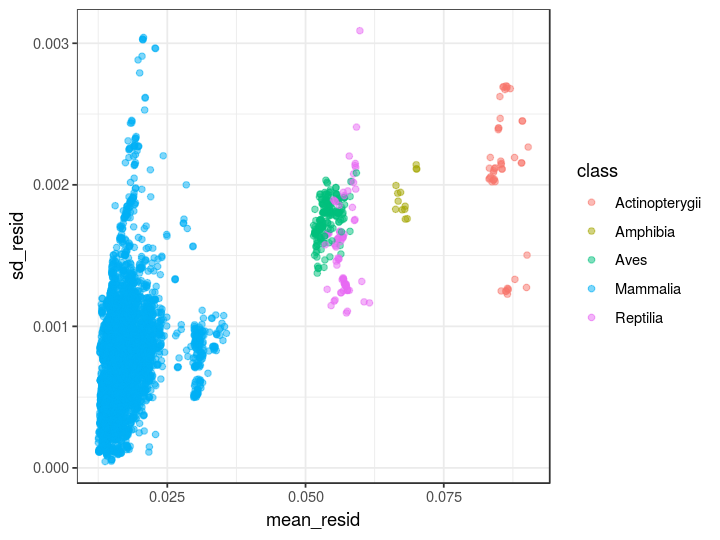

In [36]:
p = ggplot(D_links_l, aes(mean_resid, sd_resid, color=class)) +
    geom_point(alpha=0.5) +
    theme_bw() 

options(repr.plot.width=6, repr.plot.height=4.5)
plot_write(p, file='IndD_sens-family_resid_mean-sd.pdf')

#### CV resulting from intra-species variance

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3158  2.8514  4.1640  4.4456  5.9508 14.7364 


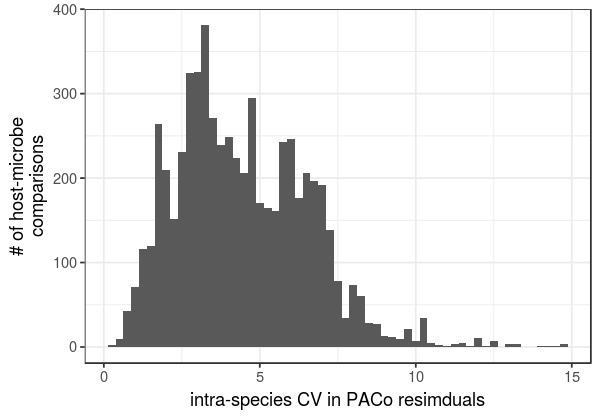

In [37]:
# CV variance due to 
D_links_l$CV_resid %>% summary %>% print

p = ggplot(D_links_l, aes(CV_resid)) +
    geom_histogram(binwidth=0.25) +
    labs(x='intra-species CV in PACo resimduals', y='# of host-microbe\ncomparisons') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3.5)
plot(p)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3158  2.8514  4.1640  4.4456  5.9508 14.7364 
File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/.figures/IndD_sens-family_resid_histo-byClass.pdf 


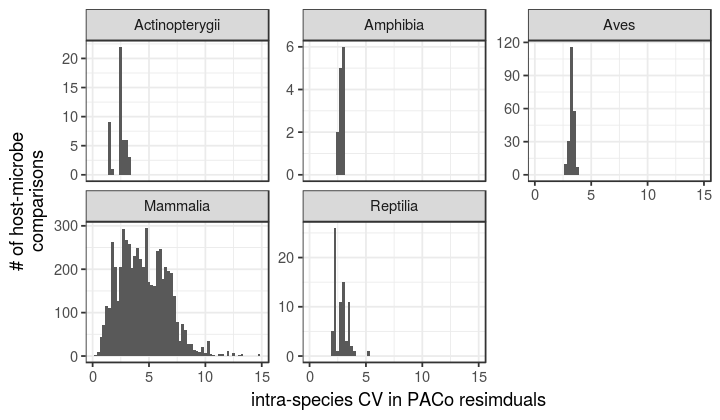

In [38]:
# CV variance due to 
D_links_l$CV_resid %>% summary %>% print

p = ggplot(D_links_l, aes(CV_resid)) +
    geom_histogram(binwidth=0.25) +
    labs(x='intra-species CV in PACo resimduals', y='# of host-microbe\ncomparisons') +
    facet_wrap(~ class, scales='free_y') +
    theme_bw()

options(repr.plot.width=6, repr.plot.height=3.5)
plot_write(p, file='IndD_sens-family_resid_histo-byClass.pdf')

#### Notes

* a rather low intra-species CV, suggesting that intra-species variation doesn't affect residuals much

### Summing residuals by host data

In [39]:
D_links_l_s = D_links_l %>% 
    dplyr::select(host, microbe, mean_resid, diet, class) %>%
    gather(category, value, -host, -microbe, -mean_resid, -class) 

D_links_l_s %>% dfhead

[1] 6077    6


host,microbe,mean_resid,class,category,value
F141.Wood.Sandpiper,8ed6829bdf1df9cdc26ac7a3d1182018,0.05249431,Aves,diet,carnivore
F141.Wood.Sandpiper,9dabdedada5e83148f6d4bff9d7bddcb,0.05262178,Aves,diet,carnivore
F141.Wood.Sandpiper,ab6bc0116bcfefcbeb981d83cd525034,0.05260776,Aves,diet,carnivore


File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/.figures/IndD_sens-family_resid_diet.pdf 


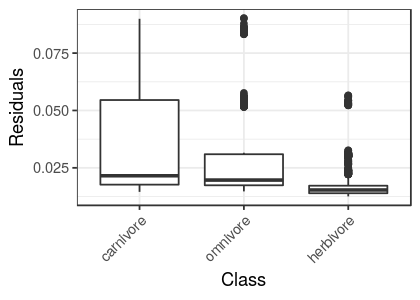

In [40]:
tmp = D_links_l %>% 
    group_by(diet) %>%
    mutate(median_resid = median(mean_resid)) %>%
    ungroup() %>%
    mutate(diet = diet %>% reorder(-median_resid))

p = ggplot(tmp, aes(diet, mean_resid)) +
    geom_boxplot() +
    labs(x='Class', y='Residuals') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=3.5, repr.plot.height=2.5)
plot_write(p, file='IndD_sens-family_resid_diet.pdf')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/.figures/IndD_sens-family_resid_class-diet.pdf 


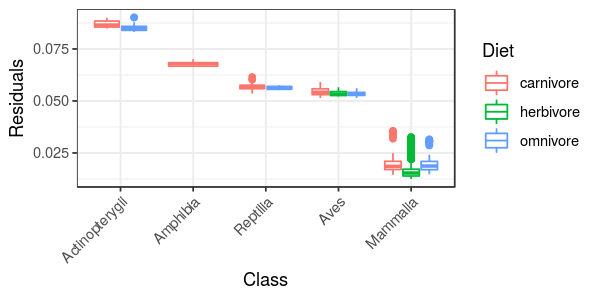

In [41]:
tmp = D_links_l_s %>% 
    group_by(class) %>%
    mutate(median_resid = median(mean_resid)) %>%
    ungroup() %>%
    mutate(class = class %>% reorder(-median_resid))

p = ggplot(tmp, aes(class, mean_resid, color=value)) +
    geom_boxplot() +
    scale_color_discrete('Diet') +
    labs(x='Class', y='Residuals') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=5, repr.plot.height=2.5)
plot_write(p, file='IndD_sens-family_resid_class-diet.pdf')

### Formatting for iTOL

In [42]:
otu_m = D_links_l %>%
    mutate(host = gsub(' ', '_', scientific_name)) %>%
    group_by(host, Genus, microbe) %>%
    summarize(mean_resid = mean(mean_resid, na.rm=TRUE)) %>%
    ungroup() %>%
    mutate(microbe = microbe %>% as.factor %>% as.numeric,
           microbe = gsub('^', 'SV', microbe)) %>%
    unite(OTU, Genus, microbe) %>%
    filter(!grepl('^_SV', OTU)) %>%
    dplyr::select(host, OTU, mean_resid) %>%
    spread(OTU, mean_resid) %>%
    as.data.frame

rownames(otu_m) = otu_m$host 
otu_m$host = NULL
rownames(otu_m) = gsub('^X', '', rownames(otu_m))

otu_m %>% dfhead

[1] 128 396


,Acinetobacter_SV134,Acinetobacter_SV157,Acinetobacter_SV159,Acinetobacter_SV179,Acinetobacter_SV214,Acinetobacter_SV306,Acinetobacter_SV364,Aeromonas_SV351,Akkermansia_SV189,Akkermansia_SV24,⋯,uncultured_SV80,uncultured_SV81,uncultured_SV84,uncultured_SV85,uncultured_SV87,uncultured_SV88,uncultured_SV89,uncultured_SV92,uncultured_SV94,uncultured_SV98
Acrocephalus_scirpaceus,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Aepyceros_melampus,NA,NA,NA,0.02078872,NA,NA,NA,NA,NA,NA,⋯,0.01847556,NA,NA,0.01536783,NA,0.01578146,NA,NA,0.01541341,NA
Anas_platyrhynchos,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [43]:
# checking overlap with host clado tips
#host_tree = read.tree(host_tree_file)
#setdiff(host_tree$tip.label, rownames(otu_m)) %>% print
#setdiff(rownames(otu_m), host_tree$tip.label) %>% print

In [44]:
itol_htmp_file = file.path(work_dir, 'physeq_IndD-sens-family_PACo-Con-links_htmp.txt')
labs = gsub(' ', '_', colnames(otu_m))
labs = sprintf('FIELD_LABELS %s\n', paste(labs, collapse=' '))

cat('DATASET_HEATMAP\n', file=itol_htmp_file)
cat('SEPARATOR SPACE\n', file=itol_htmp_file, append=TRUE)
cat('DATASET_LABEL paco_residuals\n', file=itol_htmp_file, append=TRUE)
cat('COLOR #ff0000\n', file=itol_htmp_file, append=TRUE)
cat(labs, file=itol_htmp_file, append=TRUE)
cat('DATA\n', file=itol_htmp_file, append=TRUE)
write.table(otu_m, file=itol_htmp_file, append=TRUE, sep=' ', 
            quote=FALSE, col.names=FALSE)
cat('File written:', itol_htmp_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT//physeq_IndD-sens-family_PACo-Con-links_htmp.txt 


#### iTOL: distribution of residuals per host species

In [45]:
# summing residuals by host
#ID1,minimum,q1,median,q3,maximum,extreme_value1,extreme_value2
tmp = D_links_l %>%
    filter(!is.na(mean_resid)) %>%
    mutate(host = gsub(' ', '_', scientific_name)) %>%
    group_by(host, Genus, microbe) %>%
    summarize(mean_resid = mean(mean_resid, na.rm=TRUE)) %>%
    ungroup() %>%
    group_by(host) %>%
    summarize(minimum = min(mean_resid),
              q1 = quantile(mean_resid, 0.25),
              median = median(mean_resid),
              q3 = quantile(mean_resid, 0.75),
              maximum = max(mean_resid)) %>%
    ungroup() 


tmp %>% dfhead

[1] 128   6


host,minimum,q1,median,q3,maximum
Acrocephalus_scirpaceus,0.05168766,0.05168766,0.05297412,0.05324222,0.05333531
Aepyceros_melampus,0.01529327,0.01561603,0.01654258,0.01759957,0.02089361
Anas_platyrhynchos,0.05185505,0.05368572,0.05413565,0.05560168,0.05566027


In [46]:
itol_box_file = file.path(work_dir, 'physeq_IndD-sens-family_PACo-Con-links_box.txt')

cat('DATASET_BOXPLOT\n', file=itol_box_file)
cat('SEPARATOR SPACE\n', file=itol_box_file, append=TRUE)
cat('DATASET_LABEL resid-bxplt_IndD-sens\n', file=itol_box_file, append=TRUE)
cat('COLOR #ff0000\n', file=itol_box_file, append=TRUE)
cat('DATA\n', file=itol_box_file, append=TRUE)
write.table(tmp, file=itol_box_file, append=TRUE, sep=' ', 
            quote=FALSE, row.names=FALSE, col.names=FALSE)
cat('File written:', itol_box_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT//physeq_IndD-sens-family_PACo-Con-links_box.txt 


# sessionInfo

In [47]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_phylo/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_phylo/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2          future.apply_1.0.0      future.batchtools_0.7.1
 [4] future_1.9.0            paco_0.3.2              ape_5.1                
 [7] phyloseq_1.22.3         stringr_1.3.1           ggplot2_3.0.0          
[10] tidyr_0.8.1             dplyr_0.7.6            

loaded via a namespace (and not attached):
 [1] Biobase_2.38.0      jsonlite_1.5        splines_3.4.1      
 [4] foreach_1.4.4       assertthat_0.2.0    stats4_3.4.1       
 [7] base64url_1.4       progress_1.2.0      globals_0.12.1     
[10